In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jpholiday

In [2]:
df = pd.read_excel('/Users/hiraokatatsuru/Library/CloudStorage/OneDrive-個人用/ドキュメント/物数データ.xlsx')
df.set_index('date', inplace=True)

In [3]:
def assign_season(date):
    if date.month in [3, 4, 5]:
        return 1  # 春
    elif date.month in [6, 7, 8]:
        return 2  # 夏
    elif date.month in [9, 10, 11]:
        return 3  # 秋
    else:
        return 4  # 冬

In [4]:
def generate_features(df, dates, feature_columns):
    idx    = df.index.union(dates)
    df_ext = df.reindex(idx)

    # 曜日系
    df_ext['dow']     = df_ext.index.dayofweek
    df_ext['dow_sin'] = np.sin(2*np.pi*df_ext['dow']/7)
    df_ext['dow_cos'] = np.cos(2*np.pi*df_ext['dow']/7)

    # 祝日系
    df_ext['is_holiday']             = df_ext.index.to_series().apply(jpholiday.is_holiday).astype(int)
    df_ext['is_after_holiday']       = df_ext['is_holiday'].shift(1).fillna(0).astype(int)
    df_ext['is_after_after_holiday'] = df_ext['is_holiday'].shift(2).fillna(0).astype(int)

    # 月・年末年始・お盆
    df_ext['month']       = df_ext.index.month
    df_ext['season'] = df_ext.index.map(assign_season)
    df_ext['is_new_year'] = ((df_ext.index.month == 1) & (df_ext.index.day <= 3)).astype(int)
    df_ext['is_obon']     = (
        (df_ext.index.month == 8) &
        (df_ext.index.day   >= 13) &
        (df_ext.index.day   <= 16)
    ).astype(int)

    # ラグ・移動平均
    df_ext['lag_1']          = df_ext['通常物数'].shift(1)
    df_ext['lag_7']          = df_ext['通常物数'].shift(7)
    df_ext['rolling_mean_7'] = df_ext['通常物数'].shift(1).rolling(7).mean()

    # 価格増加フラグ
    df_ext['price_increase_flag'] = 0
    df_ext.loc[df_ext.index >= pd.Timestamp('2024-10-01'), 'price_increase_flag'] = 1

    # 最終的に欲しい行・列を抽出
    return df_ext.loc[dates, feature_columns]


Fold 1 — MAE: 5112.57, RMSE: 8052.47
Fold 2 — MAE: 4771.08, RMSE: 8546.29
Fold 3 — MAE: 4520.73, RMSE: 7832.16
Fold 4 — MAE: 3773.69, RMSE: 6648.07
Fold 5 — MAE: 5930.87, RMSE: 10107.25

CV MAE:  4821.79 ± 708.00
CV RMSE: 8237.25 ± 1123.93


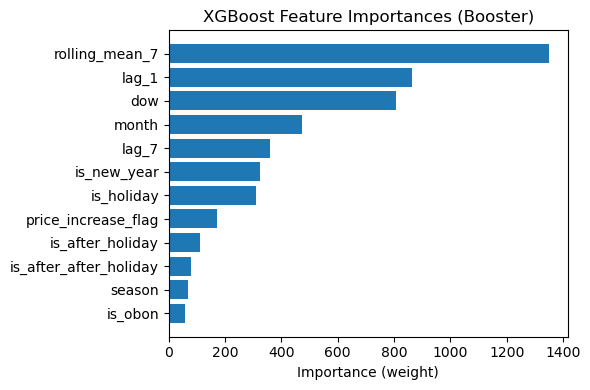

2025-06-01 (日): 0 通
2025-06-02 (月): 82000 通
2025-06-03 (火): 33000 通
2025-06-04 (水): 36000 通
2025-06-05 (木): 38000 通
2025-06-06 (金): 39000 通
2025-06-07 (土): 0 通
2025-06-08 (日): 0 通
2025-06-09 (月): 86000 通
2025-06-10 (火): 34000 通
2025-06-11 (水): 37000 通
2025-06-12 (木): 39000 通
2025-06-13 (金): 39000 通
2025-06-14 (土): 0 通
2025-06-15 (日): 0 通
2025-06-16 (月): 87000 通
2025-06-17 (火): 35000 通
2025-06-18 (水): 38000 通
2025-06-19 (木): 42000 通
2025-06-20 (金): 45000 通
2025-06-21 (土): 0 通
2025-06-22 (日): 0 通
2025-06-23 (月): 87000 通
2025-06-24 (火): 39000 通
2025-06-25 (水): 42000 通
2025-06-26 (木): 46000 通
2025-06-27 (金): 47000 通
2025-06-28 (土): 0 通
2025-06-29 (日): 0 通
2025-06-30 (月): 87000 通
2025-07-01 (火): 40000 通
2025-07-02 (水): 44000 通
2025-07-03 (木): 47000 通
2025-07-04 (金): 48000 通
2025-07-05 (土): 0 通
2025-07-06 (日): 0 通
2025-07-07 (月): 87000 通
2025-07-08 (火): 41000 通
2025-07-09 (水): 44000 通
2025-07-10 (木): 47000 通
2025-07-11 (金): 48000 通
2025-07-12 (土): 0 通
2025-07-13 (日): 0 通
2025-07-14 (月): 8700

In [17]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. データ準備 ------------------------------------------
feature_columns = [
    'dow','dow_sin','dow_cos','is_holiday','is_after_holiday','is_after_after_holiday',
    'month','season','lag_1','lag_7','rolling_mean_7',
    'is_new_year','is_obon','price_increase_flag'
]
X_all = generate_features(df, df.index, feature_columns)
y_all = df['通常物数'].loc[X_all.index]
mask = X_all.isnull().any(axis=1)
X_all, y_all = X_all.loc[~mask], y_all.loc[~mask]

# --- 2. 時系列 CV ------------------------------------------
tscv = TimeSeriesSplit(n_splits=5)
mae_list, rmse_list = [], []

for fold, (tr_idx, te_idx) in enumerate(tscv.split(X_all), 1):
    X_tr, X_te = X_all.iloc[tr_idx], X_all.iloc[te_idx]
    y_tr, y_te = y_all.iloc[tr_idx], y_all.iloc[te_idx]

    # DMatrix 化
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_te, label=y_te)

    # パラメータ
    params = {
        'objective': 'reg:squarederror',
        'eta': 0.05,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'eval_metric': 'rmse',
        'seed': 42
    }

    # train
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dvalid, 'valid')],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # 予測・評価
    y_pred = bst.predict(dvalid)
    mae = mean_absolute_error(y_te, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))

    mae_list.append(mae)
    rmse_list.append(rmse)
    print(f"Fold {fold} — MAE: {mae:.2f}, RMSE: {rmse:.2f}")

print(f"\nCV MAE:  {np.mean(mae_list):.2f} ± {np.std(mae_list):.2f}")
print(f"CV RMSE: {np.mean(rmse_list):.2f} ± {np.std(rmse_list):.2f}")

# final_bst を使って get_score() で重要度を取得
importance_dict = final_bst.get_score(importance_type='weight')
# 辞書をソートしてリスト化
keys   = sorted(importance_dict, key=importance_dict.get, reverse=True)
values = [importance_dict[k] for k in keys]

plt.figure(figsize=(6, 4))
plt.barh(keys, values)
plt.xlabel("Importance (weight)")
plt.title("XGBoost Feature Importances (Booster)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- 3. 全データ再学習 --------------------------------------
dall = xgb.DMatrix(X_all, label=y_all)
final_bst = xgb.train(
    params,
    dall,
    num_boost_round=int(bst.best_iteration * 1.2),  # 最適ブースト数の120%等で調整
    verbose_eval=False
)

# --- 4. 動的再帰予測 ----------------------------------------
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=365, freq='D')
history = df['通常物数'].copy()
carry = 0.0
preds = pd.Series(index=future_dates, dtype=float)

for dt in future_dates:
    hist_df = history.to_frame(name='通常物数')
    X_dt = generate_features(hist_df, [dt], feature_columns)
    ddt = xgb.DMatrix(X_dt)

    raw = final_bst.predict(ddt)[0]
    is_wh = jpholiday.is_holiday(dt) or dt.weekday() >= 5
    if is_wh:
        carry += raw
        pred = 0.0
    else:
        pred = raw + carry
        carry = 0.0

    preds[dt] = pred
    history[dt] = pred

# 結果の四捨五入表示
for dt, v in preds.round(-3).astype(int).items():
    wd = ['月','火','水','木','金','土','日'][dt.weekday()]
    mark = '祝' if jpholiday.is_holiday(dt) else ''
    print(f"{dt:%Y-%m-%d} ({wd}{mark}): {v} 通")


In [16]:
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import jpholiday

# --- 1. データ準備 --------------------------------------------------
# 既存コードと同様に特徴量を作成＆欠損行を削除
feature_columns = [
    'dow','is_holiday','is_after_holiday','is_after_after_holiday',
    'month','season','lag_1','lag_7','rolling_mean_7',
    'is_new_year','is_obon','price_increase_flag'
]
X_all = generate_features(df, df.index, feature_columns)
y_all = df['通常物数'].loc[X_all.index]
mask = X_all.isnull().any(axis=1)
X_all, y_all = X_all.loc[~mask], y_all.loc[~mask]

# --- 2. Optuna 目的関数 ------------------------------------------------
def objective(trial):
    # ハイパラ探索空間
    params = {
        'objective': 'reg:squarederror',
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
        'seed': 42,
        'verbosity': 0
    }

    tscv = TimeSeriesSplit(n_splits=3)
    rmse_scores = []

    for train_idx, valid_idx in tscv.split(X_all):
        X_tr, X_val = X_all.iloc[train_idx], X_all.iloc[valid_idx]
        y_tr, y_val = y_all.iloc[train_idx], y_all.iloc[valid_idx]

        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dvalid = xgb.DMatrix(X_val, label=y_val)

        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=1000,
            evals=[(dtrain, 'train'), (dvalid, 'valid')],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        pred = bst.predict(dvalid)
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

# --- 3. Optuna でチューニング ------------------------------------------------
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)

print("Best params:", study.best_params)
print("Best CV RMSE:", study.best_value)

# --- 4. 最終モデル学習 ------------------------------------------------------
best_params = study.best_params.copy()
# Optuna で得られたキー名 'eta'→'learning_rate' に合わせる場合
best_params['learning_rate'] = best_params.pop('eta')

dall = xgb.DMatrix(X_all, label=y_all)
final_bst = xgb.train(
    best_params,
    dall,
    num_boost_round= int(1.2 * study.best_trial.user_attrs.get('best_iteration', 100)),  # 調整可
    verbose_eval=False
)

# --- 5. 動的再帰予測 ------------------------------------------------------
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=28, freq='D')
history = df['通常物数'].copy()
carry = 0.0
preds = pd.Series(index=future_dates, dtype=float)

for dt in future_dates:
    hist_df = history.to_frame(name='通常物数')
    X_dt = generate_features(hist_df, [dt], feature_columns)
    ddt = xgb.DMatrix(X_dt)

    raw = final_bst.predict(ddt)[0]
    is_wh = jpholiday.is_holiday(dt) or dt.weekday() >= 5

    if is_wh:
        carry += raw
        pred = 0.0
    else:
        pred = raw + carry
        carry = 0.0

    preds[dt] = pred
    history[dt] = pred

# --- 6. 結果表示 ----------------------------------------------------------
for dt, v in preds.round(-3).astype(int).items():
    wd = ['月','火','水','木','金','土','日'][dt.weekday()]
    mark = '祝' if jpholiday.is_holiday(dt) else ''
    print(f"{dt:%Y-%m-%d} ({wd}{mark}): {v} 通")


[I 2025-06-14 17:51:04,603] A new study created in memory with name: no-name-d65bdbce-1383-46cf-b31e-093e71b80420
/var/folders/t3/j19g2ldj2ks74jzlzsqq83640000gn/T/ipykernel_23749/1936745291.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
/var/folders/t3/j19g2ldj2ks74jzlzsqq83640000gn/T/ipykernel_23749/1936745291.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
[I 2025-06-14 17:51:05,880] Trial 0 finished with value: 12103.041207980319 and parameters: {'eta': 0.048205447964755094, 'max_depth': 3, 'subsample': 0.6113383231294428, 'colsample_bytree': 0

Best params: {'eta': 0.013932649020142504, 'max_depth': 6, 'subsample': 0.8444378210895324, 'colsample_bytree': 0.9722640848443981, 'gamma': 0.9381982913026591, 'min_child_weight': 1, 'alpha': 1.6856528859510456e-08, 'lambda': 6.913383043953725e-05}
Best CV RMSE: 7890.165633425277
2025-06-01 (日): 0 通
2025-06-02 (月): 83000 通
2025-06-03 (火): 33000 通
2025-06-04 (水): 36000 通
2025-06-05 (木): 38000 通
2025-06-06 (金): 39000 通
2025-06-07 (土): 0 通
2025-06-08 (日): 0 通
2025-06-09 (月): 90000 通
2025-06-10 (火): 35000 通
2025-06-11 (水): 41000 通
2025-06-12 (木): 44000 通
2025-06-13 (金): 45000 通
2025-06-14 (土): 0 通
2025-06-15 (日): 0 通
2025-06-16 (月): 91000 通
2025-06-17 (火): 40000 通
2025-06-18 (水): 43000 通
2025-06-19 (木): 46000 通
2025-06-20 (金): 46000 通
2025-06-21 (土): 0 通
2025-06-22 (日): 0 通
2025-06-23 (月): 91000 通
2025-06-24 (火): 40000 通
2025-06-25 (水): 44000 通
2025-06-26 (木): 46000 通
2025-06-27 (金): 47000 通
2025-06-28 (土): 0 通
2025-06-29 (日): 0 通
2025-06-30 (月): 90000 通
2025-07-01 (火): 40000 通
2025-07-02

In [19]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import jpholiday

# --- 1. ベストパラメータの設定 ---------------------------------------
best_params = {
    'objective': 'reg:squarederror',
    'eta': 0.013932649020142504,
    'max_depth': 6,
    'subsample': 0.8444378210895324,
    'colsample_bytree': 0.9722640848443981,
    'gamma': 0.9381982913026591,
    'min_child_weight': 1,
    'alpha': 1.6856528859510456e-08,
    'lambda': 6.913383043953725e-05,
    'eval_metric': 'rmse',
    'seed': 42
}

# --- 2. 全データ DMatrix の用意 --------------------------------------
X_all = generate_features(df, df.index, feature_columns)
y_all = df['通常物数'].loc[X_all.index]
mask = X_all.isnull().any(axis=1)
X_all, y_all = X_all.loc[~mask], y_all.loc[~mask]
dall = xgb.DMatrix(X_all, label=y_all)

# --- 3. xgb.cv で最適ブースト回数を決定 ------------------------------
tscv = TimeSeriesSplit(n_splits=5)
# cv 用のフォールド定義
folds = []
for tr_idx, te_idx in tscv.split(X_all):
    folds.append((tr_idx, te_idx))

cv_results = xgb.cv(
    params=best_params,
    dtrain=dall,
    num_boost_round=2000,
    folds=folds,
    early_stopping_rounds=50,
    metrics=('rmse',),
    seed=42,
    verbose_eval=False
)

best_nrounds = len(cv_results)  # 最良のイテレーション数
print(f"Optimal boosting rounds: {best_nrounds}")

# --- 4. 全データで最終モデルを学習 ------------------------------------
final_bst = xgb.train(
    params=best_params,
    dtrain=dall,
    num_boost_round=best_nrounds,
    verbose_eval=False
)

# --- 5. 動的再帰予測 --------------------------------------------------
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=365, freq='D')
history = df['通常物数'].copy()
carry = 0.0
preds = pd.Series(index=future_dates, dtype=float)

for dt in future_dates:
    # その日の特徴量を再計算
    X_dt = generate_features(history.to_frame(name='通常物数'), [dt], feature_columns)
    ddt = xgb.DMatrix(X_dt)

    raw = final_bst.predict(ddt)[0]
    is_wh = jpholiday.is_holiday(dt) or dt.weekday() >= 5

    if is_wh:
        carry += raw
        pred = 0.0
    else:
        pred = raw + carry
        carry = 0.0

    preds[dt] = pred
    history[dt] = pred  # ラグ用に追加

# --- 6. 結果を丸めて表示 ----------------------------------------------
for dt, v in preds.round(-3).astype(int).items():
    wd = ['月','火','水','木','金','土','日'][dt.weekday()]
    mark = '祝' if jpholiday.is_holiday(dt) else ''
    print(f"{dt:%Y-%m-%d} ({wd}{mark}): {v} 通")


Optimal boosting rounds: 253
2025-06-01 (日): 0 通
2025-06-02 (月): 82000 通
2025-06-03 (火): 32000 通
2025-06-04 (水): 36000 通
2025-06-05 (木): 38000 通
2025-06-06 (金): 39000 通
2025-06-07 (土): 0 通
2025-06-08 (日): 0 通
2025-06-09 (月): 84000 通
2025-06-10 (火): 33000 通
2025-06-11 (水): 37000 通
2025-06-12 (木): 39000 通
2025-06-13 (金): 40000 通
2025-06-14 (土): 0 通
2025-06-15 (日): 0 通
2025-06-16 (月): 84000 通
2025-06-17 (火): 33000 通
2025-06-18 (水): 37000 通
2025-06-19 (木): 39000 通
2025-06-20 (金): 40000 通
2025-06-21 (土): 0 通
2025-06-22 (日): 0 通
2025-06-23 (月): 84000 通
2025-06-24 (火): 33000 通
2025-06-25 (水): 37000 通
2025-06-26 (木): 39000 通
2025-06-27 (金): 40000 通
2025-06-28 (土): 0 通
2025-06-29 (日): 0 通
2025-06-30 (月): 84000 通
2025-07-01 (火): 33000 通
2025-07-02 (水): 37000 通
2025-07-03 (木): 39000 通
2025-07-04 (金): 40000 通
2025-07-05 (土): 0 通
2025-07-06 (日): 0 通
2025-07-07 (月): 84000 通
2025-07-08 (火): 33000 通
2025-07-09 (水): 37000 通
2025-07-10 (木): 39000 通
2025-07-11 (金): 40000 通
2025-07-12 (土): 0 通
2025-07-13 

In [23]:
def backtest_xgb_dynamic(df, booster, feature_columns, horizon=28):
    """
    df:       元データ DataFrame（index=日付, 列 '通常物数'）
    booster:  xgb.train() で得られた Booster オブジェクト
    feature_columns: generate_features 用の列リスト
    horizon:  バックテスト期間（日数）
    """
    # --- 1. 初期化 ---
    y = df['通常物数']
    # ホールドアウト開始日
    train_end = len(y) - horizon
    # history: ホールドアウト前までの実績
    history = y.iloc[:train_end].copy()
    # carry と予測値保存用
    carry = 0.0
    preds = []

    # --- 2. ループで動的再帰予測 + キャリー ---
    for dt in y.index[train_end:]:
        # 当日の特徴量を生成
        X_dt = generate_features(
            history.to_frame(name='通常物数'),
            [dt],
            feature_columns
        )
        ddt = xgb.DMatrix(X_dt)

        # 生予測
        raw = booster.predict(ddt)[0]
        # 土日祝判定
        is_wh = jpholiday.is_holiday(dt) or dt.weekday() >= 5

        if is_wh:
            # 週末・祝日は 0 にして carry
            carry += raw
            pred = 0.0
        else:
            # 平日は carry を足してリセット
            pred = raw + carry
            carry = 0.0

        preds.append(pred)
        # history に予測結果を追加して次日のラグに使う
        history.loc[dt] = pred

    # --- 3. 指標計算 ---
    actual = y.iloc[train_end:]
    pred_array = np.array(preds, dtype=float)

    mae  = mean_absolute_error(actual, pred_array)
    rmse = np.sqrt(mean_squared_error(actual, pred_array))

    return mae, rmse

# --------------------------------------------------
# 使い方例
# --------------------------------------------------
# Booster が final_bst、元データが df、特徴量列リストが feature_columns の場合：

mae_xgb, rmse_xgb = backtest_xgb_dynamic(df, final_bst, feature_columns, horizon=28)
print(f"XGBoost Dynamic Backtest — MAE: {mae_xgb:.0f}, RMSE: {rmse_xgb:.0f}")


XGBoost Dynamic Backtest — MAE: 3228, RMSE: 4816


In [24]:
# JSON 形式で保存
final_bst.save_model('final_bst.json')